In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import sys
import torch
import torch.nn as nn
import torch.functional as F
#ROOT_DIR = "/content/drive/MyDrive/CS260/CS260_Project"
ROOT_DIR = "/content/drive/MyDrive/CS260_Project"
SRC_DIR = os.path.join(ROOT_DIR, "src")
sys.path.append(SRC_DIR)
from generate_synthetic_data import generate_synthetic_data
from load_compas_data import load_compas_data

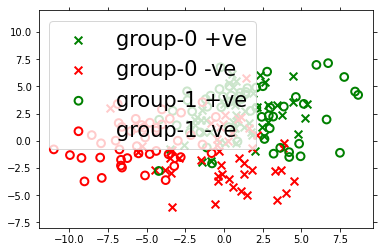

In [56]:
synth_data = generate_synthetic_data(data_type=1, plot_data=True)

In [6]:
compas_data = load_compas_data()

Looking for file 'compas-scores-two-years.csv' in the current directory...
'compas-scores-two-years.csv' not found! Downloading from GitHub...
'compas-scores-two-years.csv' download and saved locally..

Number of people recidivating within two years
-1    2795
 1    2483
dtype: int64


Features we will be using for classification are: ['intercept', 'age_cat_25 - 45', 'age_cat_Greater than 45', 'age_cat_Less than 25', 'race', 'sex', 'priors_count', 'c_charge_degree'] 



In [65]:
class LinearClassifier(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(in_dim, out_dim)
    def forward(self, x):
        out = self.linear(x)
        return out
def regularizer(z, y_pred, y, g_sign):
    meanz = torch.mean(z)
    sign_y = torch.sign(y_pred)
    gtheta = torch.clamp((1 + g_sign * sign_y)/2 * y * y_pred, max=0)
    #gtheta = torch.abs((1 + g_sign * sign_y)/2 * y * y_pred)
    expression = (z - meanz) * gtheta
    return torch.abs(torch.mean(expression))
def new_regularizer(z, y_pred, y, use_fdr=False):
    y_pred_sign = torch.sign(y_pred)
    scores = list()
    for zval in (0, 1):
        y_pred_subset = y_pred_sign[z == zval]
        y_test_subset = y[z == zval]
        fp = torch.sum(torch.logical_and(y_test_subset == -1, y_pred_subset == +1))
        fn = torch.sum(torch.logical_and(y_test_subset == +1, y_pred_subset == -1))
        tp = torch.sum(torch.logical_and(y_test_subset == +1, y_pred_subset == +1))
        tn = torch.sum(torch.logical_and(y_test_subset == -1, y_pred_subset == -1))
        fOr = fn / (fn + tn)
        fdr = fp / (tp + fp)
        scores.append(fdr if use_fdr else fOr)
    return torch.abs(scores[0] - scores[1])
class SensitiveDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, z):
        self.X = torch.Tensor(X)
        self.y = torch.unsqueeze(torch.Tensor(y), 1)
        self.z = torch.Tensor(z)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.z[idx]
def train(model, dataset, 
          n_epochs, reg_weight, g_sign, batch_size, lr,
          print_interval):
    criteron = nn.SoftMarginLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=100)

    for epoch in range(n_epochs):
        for batch_idx, batch in enumerate(dataloader):
            X, y, z = batch
            optimizer.zero_grad()
            out = model(X)
            #loss = torch.mean(torch.clamp(1 - y*out, min=0))
            #loss = 0
            loss = criteron(out, y)
            loss += reg_weight * regularizer(z, out, y, g_sign)
            #loss += reg_weight * new_regularizer(z, out, y, use_fdr=False)
            loss.backward()
            optimizer.step()
        if epoch % print_interval == 0:
            print(f"Epoch {epoch}, loss {loss.item()}")
    print(f"Epoch {epoch}, loss {loss.item()}")
def score_model(model, X_test, y_test, z, print_out=True):
    y_pred = torch.sign(model(X_test))

    subsets = (
        ("z=0", y_test[z == 0], y_pred[z == 0]),
        ("z=1", y_test[z == 1], y_pred[z == 1]),
    )
    scores = list()
    for setname, y_test_subset, y_pred_subset in subsets:
        fp = torch.sum(torch.logical_and(y_test_subset == -1, y_pred_subset == +1))
        fn = torch.sum(torch.logical_and(y_test_subset == +1, y_pred_subset == -1))
        tp = torch.sum(torch.logical_and(y_test_subset == +1, y_pred_subset == +1))
        tn = torch.sum(torch.logical_and(y_test_subset == -1, y_pred_subset == -1))
        acc = (tp+tn) / (tp+tn+fp+fn)
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)
        tpr = tp / (tp + fn)
        tnr = tn / (tn + fp)
        fOr = fn / (fn + tn)
        fdr = fp / (tp + fp)
        
        if print_out:
            print(f"{setname}: acc={acc:.2f}, fpr={fpr:.2f}, fnr={fnr:.2f}, for={fOr:.2f}, fdr={fdr:.2f}")
        scores.append([acc, fpr, fnr, fOr, fdr])
    return scores

In [67]:
n_trials = 10
for g_sign in (-1, 1):
    scores = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
    for i in range(n_trials):
        train_prop=0.5
        X, y, x_control = synth_data
        synth_dataset = SensitiveDataset(X, y, x_control["s1"])
        train_size = int(len(X)*train_prop)
        train_set, test_set = torch.utils.data.random_split(
            synth_dataset, [train_size, len(X)-train_size])
        
        model = LinearClassifier(X.shape[1], 1)
        train(model, train_set,
                n_epochs=100, reg_weight=1e9,
                g_sign=g_sign, batch_size=train_size, lr=1e-3,
                print_interval=999)
        dataloader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set))
        for batch in dataloader:
            X_test, y_test, z_test = batch
            new_scores = score_model(model, X_test, y_test, z_test)
            for z in range(2):
                for score_idx, score in enumerate(new_scores[z]):
                    scores[z][score_idx] += score
    print(f"gsign={g_sign}:")
    for z in range(2):
        for i in range(len(scores[z])):
            scores[z][i] /= n_trials
        acc, fpr, fnr, fOr, fdr = scores[z]
        print(f"\tz={z}: acc={acc:.2f}, fpr={fpr:.2f}, fnr={fnr:.2f}, for={fOr:.2f}, fdr={fdr:.2f}")

Epoch 0, loss 6.208104133605957
Epoch 99, loss 0.5785839557647705
z=0: acc=0.62, fpr=0.76, fnr=0.02, for=0.09, fdr=0.43
z=1: acc=0.77, fpr=0.44, fnr=0.00, for=0.00, fdr=0.31
Epoch 0, loss 0.6792852878570557
Epoch 99, loss 0.6103261709213257
z=0: acc=0.63, fpr=0.72, fnr=0.03, for=0.11, fdr=0.42
z=1: acc=0.83, fpr=0.33, fnr=0.02, for=0.03, fdr=0.25
Epoch 0, loss 0.5382201671600342
Epoch 99, loss 0.8714544177055359
z=0: acc=0.72, fpr=0.41, fnr=0.15, for=0.19, fdr=0.33
z=1: acc=0.84, fpr=0.25, fnr=0.06, for=0.08, fdr=0.21
Epoch 0, loss 0.7972602248191833
Epoch 99, loss 0.5203011631965637
z=0: acc=0.66, fpr=0.64, fnr=0.04, for=0.10, fdr=0.40
z=1: acc=0.81, fpr=0.39, fnr=0.02, for=0.03, fdr=0.27
Epoch 0, loss 1.3279497623443604
Epoch 99, loss 0.508328378200531
z=0: acc=0.67, fpr=0.60, fnr=0.06, for=0.14, fdr=0.38
z=1: acc=0.85, fpr=0.27, fnr=0.04, for=0.05, fdr=0.22
Epoch 0, loss 1.6230223178863525
Epoch 99, loss 0.9246506690979004
z=0: acc=0.67, fpr=0.59, fnr=0.06, for=0.12, fdr=0.40
z=1: a

In [70]:
n_trials = 10
for g_sign in (-1, 1):
    scores = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
    for i in range(n_trials):
        train_prop=0.5
        X, y, x_control = compas_data
        synth_dataset = SensitiveDataset(X, y, x_control["race"])
        train_size = int(len(X)*train_prop)
        train_set, test_set = torch.utils.data.random_split(
            synth_dataset, [train_size, len(X)-train_size])
        
        model = LinearClassifier(X.shape[1], 1)
        train(model, train_set,
                n_epochs=100, reg_weight=1e8, 
                g_sign=g_sign, batch_size=train_size, lr=1e-3,
                print_interval=999)
        dataloader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set))
        for batch in dataloader:
            X_test, y_test, z_test = batch
            new_scores = score_model(model, X_test, y_test, z_test)
            for z in range(2):
                for score_idx, score in enumerate(new_scores[z]):
                    scores[z][score_idx] += score
    print(f"gsign={g_sign}:")
    for z in range(2):
        for i in range(len(scores[z])):
            scores[z][i] /= n_trials
        acc, fpr, fnr, fOr, fdr = scores[z]
        print(f"\tz={z}: acc={acc:.2f}, fpr={fpr:.2f}, fnr={fnr:.2f}, for={fOr:.2f}, fdr={fdr:.2f}")

Epoch 0, loss 0.9885046482086182
Epoch 99, loss 0.6597296595573425
z=0: acc=0.59, fpr=0.70, fnr=0.14, for=0.34, fdr=0.43
z=1: acc=0.47, fpr=0.76, fnr=0.16, for=0.30, fdr=0.59
Epoch 0, loss 0.8216923475265503
Epoch 99, loss 0.68985515832901
z=0: acc=0.58, fpr=0.81, fnr=0.06, for=0.28, fdr=0.43
z=1: acc=0.56, fpr=0.51, fnr=0.32, for=0.29, fdr=0.55
Epoch 0, loss 0.6734614968299866
Epoch 99, loss 0.6565301418304443
z=0: acc=0.61, fpr=0.77, fnr=0.08, for=0.29, fdr=0.41
z=1: acc=0.65, fpr=0.35, fnr=0.34, for=0.24, fdr=0.46
Epoch 0, loss 0.7835515141487122
Epoch 99, loss 0.6972741484642029
z=0: acc=0.60, fpr=0.66, fnr=0.14, for=0.31, fdr=0.43
z=1: acc=0.59, fpr=0.32, fnr=0.55, for=0.34, fdr=0.53
Epoch 0, loss 0.8039557933807373
Epoch 99, loss 0.6953320503234863
z=0: acc=0.61, fpr=0.58, fnr=0.20, for=0.33, fdr=0.41
z=1: acc=0.46, fpr=0.79, fnr=0.13, for=0.28, fdr=0.60
Epoch 0, loss 1.0690357685089111
Epoch 99, loss 0.6898655295372009
z=0: acc=0.59, fpr=0.77, fnr=0.06, for=0.23, fdr=0.44
z=1: a